import required libs

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from statsmodels.regression.mixed_linear_model import MixedLM
from xgboost import XGBRegressor

# Downloading the dataset

In [2]:
df_1 = pd.read_csv("checkin_checkout_history_updated.csv")
display(df_1.head(3))
df_2 = pd.read_csv("gym_locations_data.csv")
display(df_2.head(3))
df_3 = pd.read_csv("subscription_plans.csv")
display(df_3.head(3))
df_4 = pd.read_csv("users_data.csv")
display(df_4.head(3))
table_1 = df_1.merge(df_2, right_on="gym_id", left_on="gym_id")
table_2 = df_4.merge(df_3, right_on="subscription_plan", left_on="subscription_plan")
data = table_1.merge(table_2, right_on="user_id", left_on="user_id")

,user_id,gym_id,checkin_time,checkout_time,workout_type,calories_burned
0,user_3291,gym_6,2023-09-10 15:55:00,2023-09-10 16:34:00,Weightlifting,462
1,user_1944,gym_2,2023-04-13 20:07:00,2023-04-13 22:43:00,Yoga,1278
2,user_958,gym_7,2023-06-10 12:24:00,2023-06-10 13:49:00,Cardio,858


,gym_id,location,gym_type,facilities
0,gym_1,New York,Premium,"Climbing Wall, Swimming Pool, Basketball Court"
1,gym_2,Los Angeles,Budget,"Climbing Wall, Yoga Classes, Sauna"
2,gym_3,Chicago,Budget,"Sauna, Climbing Wall, Swimming Pool"


,subscription_plan,price_per_month,features
0,Basic,19.99,"Access to basic gym facilities, Limited class ..."
1,Pro,49.99,"Access to all facilities, Unlimited class acce..."
2,Student,9.99,"Access to basic facilities, Limited class acce..."


,user_id,first_name,last_name,age,gender,birthdate,sign_up_date,user_location,subscription_plan
0,user_1,Chris,Wilson,56,Female,2000-02-29,2023-02-06,Denver,Basic
1,user_2,Michael,Miller,46,Non-binary,1978-12-22,2023-08-08,Orlando,Pro
2,user_3,Daniel,Smith,32,Female,1962-08-30,2021-01-11,Orlando,Basic


In [3]:
display(data.head(3))
data.shape

,user_id,gym_id,checkin_time,checkout_time,workout_type,calories_burned,location,gym_type,facilities,first_name,last_name,age,gender,birthdate,sign_up_date,user_location,subscription_plan,price_per_month,features
0,user_3291,gym_6,2023-09-10 15:55:00,2023-09-10 16:34:00,Weightlifting,462,Philadelphia,Budget,"Swimming Pool, Climbing Wall, Sauna",Michael,Rodriguez,41,Female,1998-03-10,2023-04-08,Atlanta,Pro,49.99,"Access to all facilities, Unlimited class acce..."
1,user_3291,gym_6,2023-09-09 08:12:00,2023-09-09 09:55:00,Weightlifting,850,Philadelphia,Budget,"Swimming Pool, Climbing Wall, Sauna",Michael,Rodriguez,41,Female,1998-03-10,2023-04-08,Atlanta,Pro,49.99,"Access to all facilities, Unlimited class acce..."
2,user_3291,gym_6,2023-07-23 19:58:00,2023-07-23 22:12:00,Cardio,1089,Philadelphia,Budget,"Swimming Pool, Climbing Wall, Sauna",Michael,Rodriguez,41,Female,1998-03-10,2023-04-08,Atlanta,Pro,49.99,"Access to all facilities, Unlimited class acce..."


(300000, 19)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            300000 non-null  object 
 1   gym_id             300000 non-null  object 
 2   checkin_time       300000 non-null  object 
 3   checkout_time      300000 non-null  object 
 4   workout_type       300000 non-null  object 
 5   calories_burned    300000 non-null  int64  
 6   location           300000 non-null  object 
 7   gym_type           300000 non-null  object 
 8   facilities         300000 non-null  object 
 9   first_name         300000 non-null  object 
 10  last_name          300000 non-null  object 
 11  age                300000 non-null  int64  
 12  gender             300000 non-null  object 
 13  birthdate          300000 non-null  object 
 14  sign_up_date       300000 non-null  object 
 15  user_location      300000 non-null  object 
 16  su

<Axes: ylabel='Frequency'>

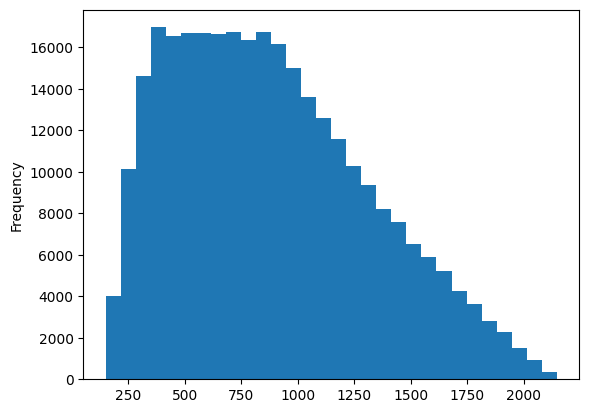

In [5]:
data["calories_burned"].plot(kind="hist", bins=30)

In [6]:
data.isna().sum(axis=0)

user_id              0
gym_id               0
checkin_time         0
checkout_time        0
workout_type         0
calories_burned      0
location             0
gym_type             0
facilities           0
first_name           0
last_name            0
age                  0
gender               0
birthdate            0
sign_up_date         0
user_location        0
subscription_plan    0
price_per_month      0
features             0
dtype: int64

In [7]:
for column in data.columns:
    print(column)
    print(data[column].nunique())
    print("------------------------------")

user_id
5000
------------------------------
gym_id
10
------------------------------
checkin_time
177713
------------------------------
checkout_time
183354
------------------------------
workout_type
6
------------------------------
calories_burned
1996
------------------------------
location
10
------------------------------
gym_type
3
------------------------------
facilities
10
------------------------------
first_name
12
------------------------------
last_name
12
------------------------------
age
47
------------------------------
gender
3
------------------------------
birthdate
4363
------------------------------
sign_up_date
1013
------------------------------
user_location
10
------------------------------
subscription_plan
3
------------------------------
price_per_month
3
------------------------------
features
3
------------------------------


# Define the function for boosting

# Новый вид после уточнения задачи на модификацию именно базового лагоритма бустинга (напр., XGBoost)

In [8]:
data = data.iloc[:10000, :].copy()
# data.iloc[:10000, :]['calories_burned'].plot(kind='hist', bins=30)

In [9]:
class BoostingRegressorFocal:
    def __init__(self, n_estimators=50, max_depth=3, learning_rate=0.1, gamma=2, early_stopping_rounds=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.early_stopping_rounds = early_stopping_rounds
        self.trees = []
        self.best_iteration = 0
        self.best_mape = float('inf')
        self.best_loss = float('inf')
        self.no_improve_count = 0

    def grad(self, residuals):
        abs_r = np.abs(residuals)
        return (self.gamma * abs_r ** (self.gamma - 1) * np.sign(residuals) * np.log(abs_r + 1) +
                (abs_r ** self.gamma) / (abs_r + 1))

    def fit(self, X, y, X_val=None, y_val=None):
        y_pred = np.zeros_like(y, dtype=np.float64)
        val_errors = []

        for t in range(self.n_estimators):
            # Calculate residuals
            residuals = y - y_pred

            # Compute gradient
            gradient = self.grad(residuals)

            # Train a new tree
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, gradient)
            self.trees.append(tree)

            # Update predictions
            y_pred += self.learning_rate * tree.predict(X)
            
            # Early stopping
            if X_val is not None and y_val is not None:
                y_val_pred = self.predict(X_val)
                current_mape = mean_absolute_percentage_error(y_val, y_val_pred)
                val_errors.append(current_mape)

                print(f"Iteration {t + 1}: Validation MAPE = {current_mape:.4f}")

                if current_mape < self.best_mape:
                    self.best_mape = current_mape
                    self.best_iteration = t + 1
                    self.no_improve_count = 0
                else:
                    self.no_improve_count += 1

                if self.no_improve_count >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {t + 1}. Best iteration: {self.best_iteration} with MAPE = {self.best_mape:.4f}")
                    break

        return val_errors

    def predict(self, X):
        y_pred = np.zeros(X.shape[0], dtype=np.float64)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Iteration 1: Validation MAPE = 0.9757
Iteration 2: Validation MAPE = 0.9518
Iteration 3: Validation MAPE = 0.9281
Iteration 4: Validation MAPE = 0.9048
Iteration 5: Validation MAPE = 0.8817
Iteration 6: Validation MAPE = 0.8590
Iteration 7: Validation MAPE = 0.8366
Iteration 8: Validation MAPE = 0.8145
Iteration 9: Validation MAPE = 0.7927
Iteration 10: Validation MAPE = 0.7713
Iteration 11: Validation MAPE = 0.7501
Iteration 12: Validation MAPE = 0.7295
Iteration 13: Validation MAPE = 0.7095
Iteration 14: Validation MAPE = 0.6903
Iteration 15: Validation MAPE = 0.6718
Iteration 16: Validation MAPE = 0.6542
Iteration 17: Validation MAPE = 0.6375
Iteration 18: Validation MAPE = 0.6218
Iteration 19: Validation MAPE = 0.6072
Iteration 20: Validation MAPE = 0.5937
Iteration 21: Validation MAPE = 0.5812
Iteration 22: Validation MAPE = 0.5695
Iteration 23: Validation MAPE = 0.5588
Iteration 24: Validation MAPE = 0.5488
Iteration 25: Validation MAPE = 0.5395
Iteration 26: Validation MAPE = 0.

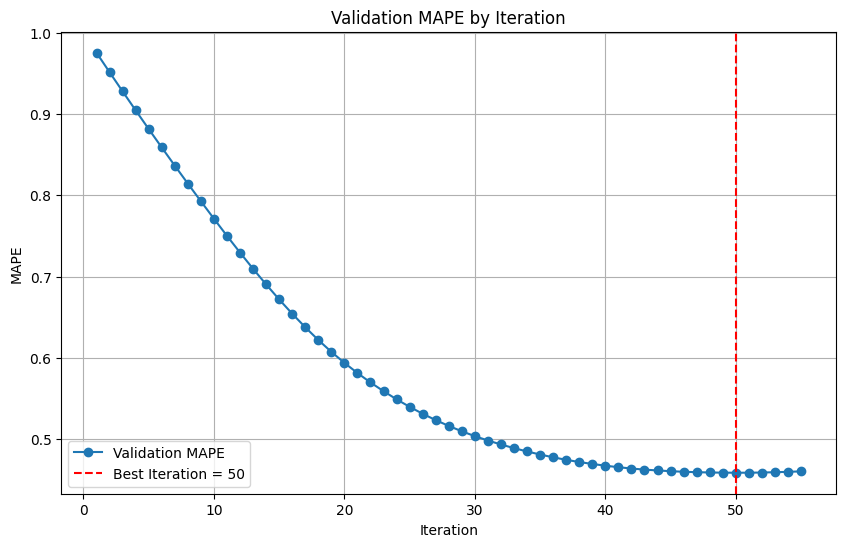

Total execution time: 3.16 minutes


In [10]:
# Засекаем время выполнения
start_time = time.time()

X = data.drop(columns='calories_burned')
y = data['calories_burned']

# Разделение на тренировочную и тестовую выборки
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Разделяем тренировочную выборку на обучение и валидацию
X_train_inner, X_val, y_train_inner, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Преобразование данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BoostingRegressorFocal(n_estimators=300, max_depth=3, learning_rate=0.05, gamma=1.5, early_stopping_rounds=5))
])

# Обучение модели
model = pipeline.named_steps['model']
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train_inner)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

val_errors = model.fit(X_train_transformed, y_train_inner, X_val_transformed, y_val)

# Прогнозы и оценка
y_pred = model.predict(X_test_transformed)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

print("Final Test MAPE:", test_mape)

# График валидационной ошибки
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_errors) + 1), val_errors, marker='o', label="Validation MAPE")
plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Best Iteration = {model.best_iteration}')
plt.title("Validation MAPE by Iteration")
plt.xlabel("Iteration")
plt.ylabel("MAPE")
plt.legend()
plt.grid()
plt.show()

# Вывод времени выполнения
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Total execution time: {elapsed_time:.2f} minutes")

# XGBoost

In [11]:
start_time = time.time()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=500, n_jobs=-1))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print("Final Test MAPE:", test_mape)

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Total execution time: {elapsed_time:.2f} minutes")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Final Test MAPE: 0.5740862343362486
Total execution time: 17.43 minutes
